In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

from tqdm import tqdm 
import h5py

In [7]:
%run ../../codes/statistics.py
%run ../../codes/GCN.py

In [3]:
lr_list = np.array([np.power(0.5, i) for i in range(2, 16, 2)])
lr_ary = np.array([np.power(0.5, i) for i in range(2, 16, 2)]*10)

In [42]:
file_dir = '/Users/qingyao/../../Volumes/Seagate_Qing/branching_data/gnn_regression_1d5/'

In [73]:
x_number = 50
# x_folder = 'regression_ng_{}'.format(x_number)
# x_folder = 'regression_{}_layer_{}'.format(x_number,4)
x_folder = 'regression_ng_{}_layer_{}'.format(x_number,4)

In [74]:
for slipt_idx in range(10):
    test_mse_best, lr, test_mse_position = find_best_learning_rate_and_test_mse(file_dir,
                                                                                50,4,slipt_idx,lr_list,0)
    print(slipt_idx,test_mse_best,test_mse_position)

0 0.4461663360633547 10
1 0.4625441772597177 10
2 0.4541504968726446 17
3 0.43825019295253453 66
4 0.46415080078064447 17
5 0.45166702355657307 52
6 0.44374969573248 24
7 0.41221095758771137 17
8 0.46287620682564995 9
9 0.4128230046658289 10


In [62]:
# with h5py.File(file_dir+x_folder+'/res_{}_{}.hdf5'.format(7, 17), 'r') as f:
#     val_loss = f['val_mse'][()]
#     predictions_np = f['predictions'][:]
#     y_true_np = f['y_true'][:]
#     test_mse_val = f['test_mse'][()]

In [75]:
results = {}
for slipt_idx in range(10):
    with h5py.File(file_dir+x_folder+'/res_{}_{}.hdf5'.format(9, 10), 'r') as f:
        val_loss = f['val_mse'][()]
        predictions_np = f['predictions'][:]
        y_true_np = f['y_true'][:]
        test_mse_val = f['test_mse'][()]
        for p, t in zip(predictions_np.ravel(), y_true_np.ravel()):
            real_r = np.round(np.exp(t),3)
    #     print(real_r)
            if real_r in results.keys():
                results[real_r].append(p)
            else:
                results[real_r] = [p]

In [76]:
R0 = 1.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025, 5.   ,  2.5  , 13.333,  3.333,  1.333,  0.667,  0.286,  0.133,
        0.067,  0.033,0.37,7.4])

In [77]:
rs.sort()

In [78]:
Bootstrap_ci = []
Bootstrap_mean = []
per_95 = []
per_5 = []
for r_idx in range(21):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
    per_95.append(np.percentile(data,95))
    per_5.append(np.percentile(data,5))

0.025
0.033
0.05
0.067
0.1
0.133
0.2
0.286
0.37
0.5
0.667
1.0
1.333
2.0
2.5
3.333
5.0
7.4
10.0
13.333
20.0


In [79]:
CI = np.array(Bootstrap_ci)

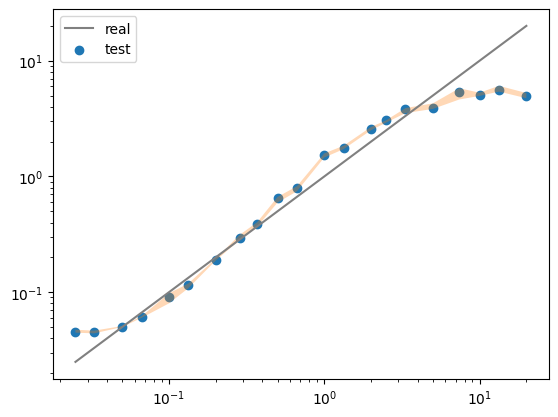

In [80]:
plt.plot(rs,rs,label='real',c='grey')
plt.scatter(rs,np.array(Bootstrap_mean),label='test')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [28]:
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
           5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
        0.067:3,  0.033:3, 0.37:2,7.4:0}

In [ ]:
rs
# for r_idx in range(21):
#     r = rs[r_idx]
#     k = np.log(r)
#     c = r_class[r]
#     r = np.float32(r)
#     # Plot each boxplot at position k_idx + 1
# #     y = np.exp()
# #     ax.boxplot(results[k], positions=[k_idx + 1])
# #     real_pr = np.exp(results[r])
# #     std_list.append(np.std(real_pr))
# #     median_list.append(np.median(real_pr))

    
# #     ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
# #                boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
# #                whiskerprops=line_properties, widths=0.4,
# #            capprops=line_properties,
# #               medianprops=dict(linestyle='-', linewidth=1, color='gray'))
    
#     myc = colors[c]
#     # Plot the scatter point at the same position
#     ax.scatter(r, r, color='orangered', s=5,alpha=1)

#     print(len(results[r]))
# plt.plot(rs, median_list,ls='--',lw=0.7)

# Show the plot after adding all boxplots
# label_pos = np.array([0,2,4,6,8,10,12,15,16,18])+1
# ax.set_xticks(label_pos)  # Setting x-ticks positions
# ax.set_xticklabels(rs[[0,2,4,6,8,10,12,15,16,18]])  # Assuming 'rs' is your array of labels

[12.5   4.    0.4   0.08]


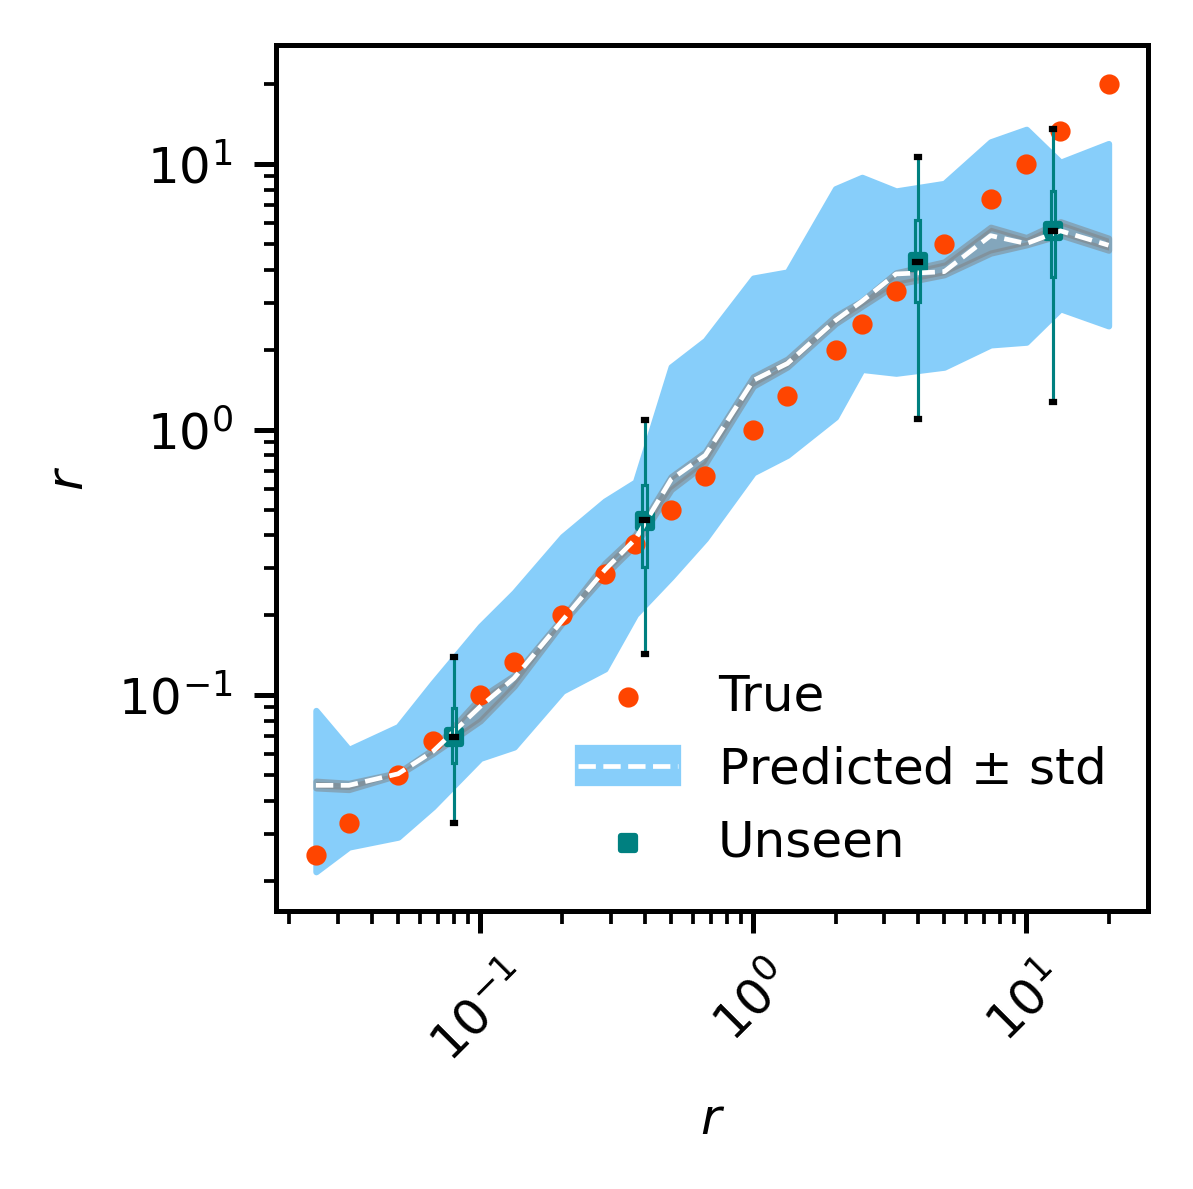

In [97]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(2.5,2.5),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

line_properties = dict(linestyle='-', linewidth=0.75, color='gray')

# plt.plot(rs,rs,label='real',c='white',ls='--',)
lines = plt.plot(rs,np.array(Bootstrap_mean),ls='--',lw=0.75,color='white')
# plt.scatter(rs,np.array(Bootstrap_mean),lw=0.7,color='orangered')
line_object = lines[0]

ax.fill_between(rs, np.array(per_5),np.array(per_95),
                 alpha=1,color='lightskyblue',label=r'Predicted$\pm$std')


ax.fill_between(rs,CI[:,1],CI[:,0],alpha=0.5,color='grey')
trues = plt.scatter(rs, rs, color='orangered', s=5,alpha=1,label='True')

print(rs_add)
# ax.boxplot(data_for_box, positions=rs_add, widths=0.02, showfliers=False)
unseen = ax.scatter(rs_add,np.array(Bootstrap_mean_u),label='Unseen',s=5,
           facecolor='teal',marker='s',edgecolor='teal')

widths = [0.4,0.15,0.015,0.003]  # Adjust the 0.05 value as needed

# Add the box plot with calculated widths
box = ax.boxplot(data_for_box, positions=rs_add, widths=widths, patch_artist=True,showfliers=False)

# Set the color of all boxes to 'teal'
for patch in box['boxes']:
    patch.set_facecolor('None')
    patch.set_linewidth(0.5)
    patch.set_edgecolor('teal')

whisker_linewidth = 0.5  # Example linewidth
for whisker in box['whiskers']:
    whisker.set_linewidth(whisker_linewidth)
    whisker.set_color('teal')
#     patch.set_color('teal')
for median in box['medians']:
    median.set_color('black')
    


plt.xticks(rotation=45)
ax.set_yscale('log')
ax.set_xscale('log')

# plt.ylim(-5,4)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.legend(frameon=False,fontsize=8)
# Create custom legend
# Create a custom legend symbol
class CustomHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch_height = height * 1  # Increase the height of the shaded area
        patch = mpatches.Rectangle([x0, y0 + (height - patch_height) / 2], width, patch_height, color='lightskyblue', transform=handlebox.get_transform())
        line = mlines.Line2D([x0, x0 + width], [y0 + height / 2, y0 + height / 2], linestyle='--', lw=0.75, color='white', transform=handlebox.get_transform())
        handlebox.add_artist(patch)
        handlebox.add_artist(line)
        return [patch, line]

# Create legend
plt.legend([trues,line_object,unseen], ['True', r'Predicted $\pm$ std','Unseen'], 
           handler_map={line_object: CustomHandler()}, loc='lower right', frameon=False,fontsize=8)
# plt.show()
plt.savefig("gnn_regression_ng_1d5.pdf", bbox_inches='tight', pad_inches=0)
# plt.savefig('gnn_regression_ng_1d5.eps',bbox_inches='tight',format='eps')

In [81]:
model = GCN_ng(num_node_features=50, hidden_channels=[
        128, 64, 16, 8], num_hlayers=4)  # Replace 'GCN' and 'num_x' with actual values
# Load the saved state dictionary
model.load_state_dict(torch.load(file_dir+x_folder+'/best_model_{}_{}.pth'.format(9,10)))

<All keys matched successfully>

In [82]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [83]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary
g_s = nx.from_numpy_array(WN)
edges = np.array(g_s.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)
# edge_weight = torch.tensor(WN[edge_index[0], edge_index[1]], dtype=torch.float)
edge_weights = []
for (u, v) in g_s.edges():
    edge_weights.append([g_s[u][v]['weight']])
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

In [84]:
R0

1.5

In [85]:
rs_add = np.array([12.5 ,  4.  ,  0.4 ,  0.08])
export_dir = '/Users/qingyao/../../Volumes/Seagate_Qing/branching_data/simulation/unseen/'
#### data preparation
dataset = []
r_class = {12.5:0 ,  4.:1  ,  0.4:2 ,  0.08:3}
for r_idx in range(4):
    r = rs_add[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:] 
        
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
#         y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

12.5 0
4.0 1
0.4 2
0.08 3


In [86]:
def test(model, testloader, device):
    model.eval()
    predictions = []
    total_loss = 0
    true_values = []
    with torch.no_grad():
        for data in testloader:
            data = data.to(device)
            output = model(data)
            loss = F.mse_loss(output, data.y)
            total_loss += loss.item() * data.num_graphs
            predictions.append(output.cpu())
            true_values.append(data.y.cpu())
    return torch.cat(predictions, dim=0), torch.cat(true_values, dim=0), total_loss / len(testloader.dataset)

In [87]:
testloader = DataLoader(dataset, batch_size=128, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [88]:
predictions_u, y_true_u, test_mse_u = test(model, testloader, device)

In [89]:
print(f"Test MSE: {test_mse_u:.4f}")

Test MSE: 0.4079


In [90]:
results_u = {}
for p, t in zip(predictions_u.ravel().numpy(), y_true_u.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results_u.keys():
        results_u[real_r].append(p)
    else:
        results_u[real_r] = [p]

In [91]:
Bootstrap_ci_u = []
Bootstrap_mean_u = []
per_95_u = []
per_5_u = []
data_for_box = []
for r_idx in range(4):
    r = rs_add[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results_u[r])
    data_for_box.append(data)
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci_u.append([l_b, u_b])
    Bootstrap_mean_u.append(sample_median)
    per_95_u.append(np.percentile(data,95))
    per_5_u.append(np.percentile(data,5))

12.5
4.0
0.4
0.08


In [92]:
CI_u = np.array(Bootstrap_ci_u)

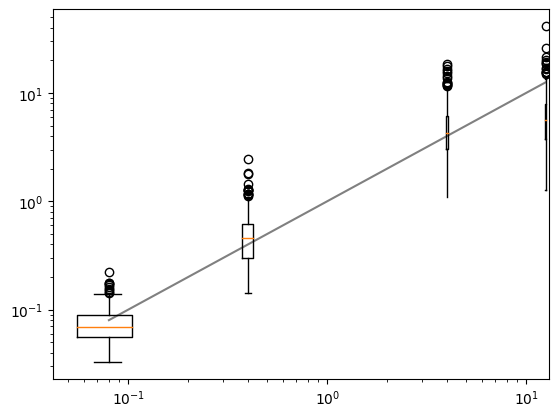

In [93]:
plt.plot(rs_add,rs_add,label='real',c='grey')

plt.boxplot(data_for_box, positions=rs_add, widths=0.05)
plt.yscale('log')
plt.xscale('log')
plt.show()

# plt.scatter(rs_add,np.array(Bootstrap_mean_u),label='test')
# plt.fill_between(rs_add,CI_u[:,1],CI_u[:,0],alpha=0.3)

# plt.legend()

In [ ]:
lr_list = [np.power(0.5, i) for i in range(2, 16, 2)]*10

In [ ]:
lr_list[:7]